In [9]:
import os
import cv2
from tqdm import tqdm
from util import read_images
from preprocessing import preprocess_image
%load_ext autoreload
%autoreload 2

folders =[]
# iterate over all folder in raw
raw_path = "data/raw"
for data_type_folder in os.listdir(raw_path):
    for skin_cancer_type_folder in os.listdir(os.path.join(raw_path, data_type_folder)):
          folders.append(os.path.join( data_type_folder, skin_cancer_type_folder))

for folder in folders:
  raw_path_folder = os.path.join(raw_path, folder)
  preprocessed_path_folder = os.path.join("data/preprocessed", folder)
  
  images = read_images(raw_path_folder)
  for i, (image_array, label) in enumerate(tqdm(images)):
      preprocessed_image = preprocess_image(image_array)
      

      # Save the image
      image_path = os.path.join(preprocessed_path_folder, f"{label}")
      cv2.imwrite(image_path, preprocessed_image)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 300/300 [00:01<00:00, 163.55it/s]


KeyboardInterrupt: 

In [ ]:
# feature extraction

import pandas as pd
from tqdm import tqdm

from featureextraction import calculate_hog_with_pca, get_file_path_with_label, calculate_texture_features, calculate_rgb_statistic, calculate_hsv_statistic, calculate_lab_statistic, calculate_shape_features
%load_ext autoreload
%autoreload 2

preprocessed_path = "data/preprocessed/"
train_features, test_features = get_file_path_with_label(preprocessed_path)

def extract_glcm_color_features(image_path: str) -> pd.Series:
    image = cv2.imread(image_path)
    
    features = []
    features.append(calculate_texture_features(image))
    features.append(calculate_shape_features(image))
    features.append(calculate_rgb_statistic(image))
    features.append(calculate_hsv_statistic(image))
    features.append(calculate_lab_statistic(image))
    
    combined_features = pd.concat(features, axis=0)
    return pd.Series(combined_features)

tqdm.pandas(desc="Extracting GLCM and Color Features On Test Set")
preprocessed_test = test_features["image_path"].progress_apply(
    lambda x: extract_glcm_color_features(x)
)

test_features = pd.concat(
    [
        test_features,
        preprocessed_test,
        calculate_hog_with_pca(test_features["image_path"])
    ],
    axis=1,
)

tqdm.pandas(desc="Extracting GLCM and Color Features On Train Set")
preprocessed_train = train_features["image_path"].progress_apply(
    lambda x: extract_glcm_color_features(x)
)

train_features = pd.concat(
    [
        train_features,
        preprocessed_train,
        calculate_hog_with_pca(train_features["image_path"])
    ],
    axis=1,
)

# save the features
train_features.to_csv("data/features/train_features.csv", index=False)
test_features.to_csv("data/features/test_features.csv", index=False)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Extracting GLCM and Color Features On Train Set:  81%|████████  | 2131/2637 [02:45<00:36, 13.70it/s]c:\Users\drith\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\drith\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\drith\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1193: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
c:\Users\drith\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1303: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
c:\Users\drith\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\drith\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3747: RuntimeW

In [1]:
%load_ext autoreload
%autoreload 2
from lightgbm import LGBMClassifier
import pandas as pd
from matplotlib import pyplot as plt
import lightgbm as lgb

train_df = pd.read_csv("data/features/train_features.csv")
test_df = pd.read_csv("data/features/test_features.csv")

display(train_df.head())

# drop the image path
train_df.drop(columns=["image_path"], inplace=True)
test_df.drop(columns=["image_path"], inplace=True)

# drop hog features (starts with HOG_PCA)
# hog_columns = [col for col in train_df.columns if col.startswith("hog")]
# train_df.drop(columns=hog_columns, inplace=True)
# test_df.drop(columns=hog_columns, inplace=True)

# glcm_columns = [col for col in train_df.columns if col.startswith("glcm")]
# train_df.drop(columns=glcm_columns, inplace=True)
# test_df.drop(columns=glcm_columns, inplace=True)

# drop shape features
# shape_columns = [col for col in train_df.columns if col.startswith("shape")]
# train_df.drop(columns=shape_columns, inplace=True)  
# test_df.drop(columns=shape_columns, inplace=True)


# find columns with missing values
missing_columns = train_df.columns[train_df.isnull().any()].tolist()
print(missing_columns)

# do simple imputation
train_df.fillna(train_df.mean(), inplace=True)
test_df.fillna(test_df.mean(), inplace=True)

X_train = train_df.drop(columns=["label"])
y_train = train_df["label"]

X_test = test_df.drop(columns=["label"])
y_test = test_df["label"]

display(train_df)
display(test_df)

,image_path,label,glcm_contrast,glcm_energy,glcm_homogeneity,glcm_correlation,shape_area,shape_mean,shape_std_dev,shape_variance,...,hog_pca_90,hog_pca_91,hog_pca_92,hog_pca_93,hog_pca_94,hog_pca_95,hog_pca_96,hog_pca_97,hog_pca_98,hog_pca_99
0,data/preprocessed/train\benign\100.jpg,0,96.314421,0.842023,0.889208,0.925281,7347.0,8.756457,25.255090,637.819593,...,-0.257736,-0.041781,-0.100024,-0.085278,-0.138664,0.211276,-0.412162,0.006875,0.118611,0.198241
1,data/preprocessed/train\benign\1000.jpg,0,69.949312,0.860061,0.904631,0.932363,6426.0,7.144770,22.617259,511.540425,...,0.016734,-0.359356,-0.127119,-0.146085,-0.196135,0.229773,-0.343456,0.139024,0.209246,0.119273
2,data/preprocessed/train\benign\1001.jpg,0,141.161339,0.616404,0.755495,0.959801,18138.0,27.598354,41.762076,1744.070963,...,0.012727,0.200903,0.153136,-0.006286,0.382263,-0.076754,0.365880,-0.221041,0.013773,-0.106197
3,data/preprocessed/train\benign\1002.jpg,0,431.996791,0.517896,0.716687,0.953286,23023.0,52.629763,68.127782,4641.394713,...,-0.110729,0.234009,-0.085882,0.648773,0.188863,-0.137751,-0.393566,-0.157114,-0.047617,-0.230327
4,data/preprocessed/train\benign\1004.jpg,0,274.711059,0.543754,0.718011,0.969052,21981.0,52.839605,66.535608,4426.987108,...,-0.426765,0.057815,0.430070,0.158599,0.393813,0.434175,0.303622,0.101978,-0.090341,-0.182087


['rgb_mean_b', 'rgb_mean_g', 'rgb_mean_r', 'rgb_var_b', 'rgb_var_g', 'rgb_var_r', 'rgb_skew_b', 'rgb_skew_g', 'rgb_skew_r', 'rgb_kurt_b', 'rgb_kurt_g', 'rgb_kurt_r', 'hsv_mean_h', 'hsv_mean_s', 'hsv_mean_v', 'hsv_var_h', 'hsv_var_s', 'hsv_var_v', 'hsv_skew_h', 'hsv_skew_s', 'hsv_skew_v', 'hsv_kurt_h', 'hsv_kurt_s', 'hsv_kurt_v', 'lab_mean_l', 'lab_mean_a', 'lab_mean_b', 'lab_var_l', 'lab_var_a', 'lab_var_b', 'lab_skew_l', 'lab_skew_a', 'lab_skew_b', 'lab_kurt_l', 'lab_kurt_a', 'lab_kurt_b']


,label,glcm_contrast,glcm_energy,glcm_homogeneity,glcm_correlation,shape_area,shape_mean,shape_std_dev,shape_variance,rgb_mean_b,...,hog_pca_90,hog_pca_91,hog_pca_92,hog_pca_93,hog_pca_94,hog_pca_95,hog_pca_96,hog_pca_97,hog_pca_98,hog_pca_99
0,0,96.314421,0.842023,0.889208,0.925281,7347.0,8.756457,25.255090,637.819593,59.911705,...,-0.257736,-0.041781,-0.100024,-0.085278,-0.138664,0.211276,-0.412162,0.006875,0.118611,0.198241
1,0,69.949312,0.860061,0.904631,0.932363,6426.0,7.144770,22.617259,511.540425,49.083249,...,0.016734,-0.359356,-0.127119,-0.146085,-0.196135,0.229773,-0.343456,0.139024,0.209246,0.119273
2,0,141.161339,0.616404,0.755495,0.959801,18138.0,27.598354,41.762076,1744.070963,60.282548,...,0.012727,0.200903,0.153136,-0.006286,0.382263,-0.076754,0.365880,-0.221041,0.013773,-0.106197
3,0,431.996791,0.517896,0.716687,0.953286,23023.0,52.629763,68.127782,4641.394713,128.736689,...,-0.110729,0.234009,-0.085882,0.648773,0.188863,-0.137751,-0.393566,-0.157114,-0.047617,-0.230327
4,0,274.711059,0.543754,0.718011,0.969052,21981.0,52.839605,66.535608,4426.987108,103.891216,...,-0.426765,0.057815,0.430070,0.158599,0.393813,0.434175,0.303622,0.101978,-0.090341,-0.182087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2632,1,492.650077,0.261729,0.534465,0.944636,35948.0,88.104193,66.615366,4437.607009,124.278516,...,-0.177542,0.472832,0.214753,0.065601,0.263769,-0.256859,-1.028968,0.367606,0.644586,-0.729937
2633,1,144.220872,0.818784,0.877948,0.920717,8339.0,10.293168,30.164918,909.922303,68.820330,...,-0.072390,-0.322462,0.241522,0.430346,-0.242353,0.555707,-0.098349,-0.312374,-0.144924,0.045054
2634,1,219.292770,0.494933,0.668431,0.945169,24082.0,34.901786,44.616517,1990.633610,65.035046,...,0.250537,-0.088422,-0.447146,-0.158001,0.278686,-1.068790,-0.274867,0.123707,-0.614127,-0.135692
2635,1,209.759795,0.776790,0.851819,0.959443,10394.0,22.138772,50.608003,2561.169937,75.992801,...,0.185229,-0.159044,-0.070251,0.028615,0.515664,0.064237,0.180646,0.278828,-0.025940,0.357319


,label,glcm_contrast,glcm_energy,glcm_homogeneity,glcm_correlation,shape_area,shape_mean,shape_std_dev,shape_variance,rgb_mean_b,...,hog_pca_90,hog_pca_91,hog_pca_92,hog_pca_93,hog_pca_94,hog_pca_95,hog_pca_96,hog_pca_97,hog_pca_98,hog_pca_99
0,0,96.629161,0.934126,0.954020,0.914090,2905.0,4.535794,23.578261,555.934385,81.158462,...,0.047045,0.096143,-0.027547,0.003813,0.015541,0.073558,0.157869,-0.144859,0.052150,0.158669
1,0,329.943654,0.674323,0.780407,0.952885,15288.0,33.272600,58.966738,3477.076199,98.614666,...,-0.328207,-0.277917,0.485953,0.571359,0.150126,0.299313,0.143063,0.338762,0.299343,-0.420265
2,0,178.421753,0.537634,0.696717,0.956731,22196.0,35.179329,45.361323,2057.649601,58.287623,...,0.159806,-0.091108,0.355949,-0.150664,0.060481,0.129787,0.059487,0.206896,0.518469,-0.132577
3,0,232.460309,0.586959,0.800749,0.982316,20149.0,61.146285,81.053432,6569.658806,152.056782,...,0.519872,-0.038082,0.198056,-0.010091,0.331056,0.284723,0.394354,0.096705,-0.312769,0.600142
4,0,254.746646,0.681246,0.812473,0.965921,15063.0,35.055106,60.938202,3713.464418,107.550653,...,0.187364,-0.443606,0.169168,0.099881,0.186715,-0.202342,-0.046976,-0.028892,-0.075428,-0.409450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,1,152.059232,0.648281,0.753001,0.949101,16703.0,23.798071,38.506704,1482.766224,71.980669,...,0.051517,0.088229,0.309328,0.275427,0.033965,0.319557,-0.038986,-0.063725,0.107566,0.161474
656,1,180.487916,0.723639,0.817122,0.947928,12752.0,20.394133,41.441781,1717.421230,79.775316,...,0.440134,-0.076820,-0.597334,0.100872,-0.640221,-0.336146,0.101439,0.043911,-0.060769,-0.119858
657,1,428.677000,0.207945,0.420777,0.917765,38526.0,68.963170,51.256012,2627.178769,87.441192,...,0.013852,-0.635594,0.024853,-0.048628,0.437262,0.626397,0.361604,0.305952,-0.680188,0.194904
658,1,174.866190,0.589609,0.716800,0.931852,19327.0,22.961655,35.694935,1274.128393,54.260602,...,0.306924,-0.400721,0.304371,-0.450852,0.069880,0.081531,-0.222365,-0.031101,0.071056,0.157843


In [10]:
pip uninstall scikit-learn

^C
Note: you may need to restart the kernel to use updated packages.


In [3]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
import numpy as np

# Define the parameter grid for random search
param_grid = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': np.logspace(-4, 0, 4),
    'num_leaves': [16, 32, 64],
    'colsample_bytree': np.linspace(0.6, 1.0, 5),
    'subsample': np.linspace(0.6, 1.0, 5),
    'max_depth': [6, 8, 10],
    'reg_alpha': np.logspace(-3, 0, 4),
    'reg_lambda': np.logspace(-3, 0, 4),
    'min_split_gain': np.linspace(0.0, 0.1, 5),
    'min_child_weight': [20, 30, 40],
}

# Create the LightGBM classifier
lgbm = LGBMClassifier(silent=-1, verbose=-1)

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    lgbm,
    param_distributions=param_grid,
    n_iter=10,  # Adjust the number of iterations as needed
    scoring='accuracy',  # Use an appropriate scoring metric
    cv=5,  # Number of cross-validation folds
    verbose=2,
    n_jobs=-1,  # Use all available CPU cores
    random_state=42,  # Set a random seed for reproducibility
)

# Example usage:
X_train = train_df.drop(columns=["label"])
y_train = train_df["label"]
# Assuming you have your training data X_train and corresponding labels y_train
random_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'subsample': 0.9, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'num_leaves': 32, 'n_estimators': 1000, 'min_split_gain': 0.025, 'min_child_weight': 20, 'max_depth': 10, 'learning_rate': 0.046415888336127774, 'colsample_bytree': 0.6}
Best Score: 0.79826706342361


In [8]:
# fit lightgbm

from sklearn.svm import SVC
from xgboost import XGBClassifier

# Best Hyperparameters: {'subsample': 0.7, 'reg_lambda': 0.01, 'reg_alpha': 0.001, 'num_leaves': 64, 'n_estimators': 500, 'min_split_gain': 0.025, 'min_child_weight': 20, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
lgbm = LGBMClassifier(  
    subsample=0.7,
    reg_lambda=0.01,
    reg_alpha=0.001,
    num_leaves=64,
    n_estimators=500,
    min_split_gain=0.025,
    min_child_weight=20,
    max_depth=10,
    learning_rate=0.01,
    colsample_bytree=0.6,
    silent=-1,
    verbose=-1,
)

# svm = SVC(kernel="linear", C=10, gamma=0.1, random_state=42, probability=True)

# svm.fit(
#     X_train,
#     y_train,
# )


lgbm.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
)

# classification report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("LightGBM")
y_pred = lgbm.predict(X_test)
y_pred_proba = lgbm.predict_proba(X_test)

y_pred_proba = pd.DataFrame(y_pred_proba)
y_pred_proba.to_csv("data/lgbm_y_pred_proba.csv", index=False, float_format="%.5f")

print(classification_report(y_test, y_pred))



# confusion matrix
# cm = confusion_matrix(test_df["label"], y_pred)
# sns.heatmap(cm, annot=True, fmt="d")

# misclassified_indices = test_df.index[test_df["label"] != y_pred]
# # Display the misclassified instances
# misclassified_df = test_df.loc[misclassified_indices]
# print("Misclassified Instances:")
# display(misclassified_df)

# plot feature importance
# lgb.plot_importance(lgbm, importance_type="gain", max_num_features=15)
# plt.show()



LightGBM
              precision    recall  f1-score   support

           0       0.91      0.71      0.80       360
           1       0.73      0.92      0.81       300

    accuracy                           0.80       660
   macro avg       0.82      0.81      0.80       660
weighted avg       0.83      0.80      0.80       660



In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# Generate some example data
# Assuming X_train, y_train, X_test, y_test are your training and testing data
# X_train and X_test should be the patterns, and y_train and y_test should be the corresponding labels

# Define the PNN architecture
model = models.Sequential()

# Input layer
model.add(layers.InputLayer(input_shape=(X_train.shape[1],)))

# Pattern layer
model.add(layers.Dense(64, activation='softmax'))  # You may adjust the number of units as needed

# Summation layer
model.add(layers.Lambda(lambda x: tf.reduce_sum(x, axis=1)))

# Output layer
model.add(layers.Dense(len(np.unique(y_train)), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')


ValueError: Input 0 of layer "dense_3" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (None,)

In [12]:

import pandas as pd
import numpy as np

# save ypred to csv
df = pd.DataFrame(y_pred, columns=["label"])
df.to_csv("data/lgbm_ypred.csv", index=False)

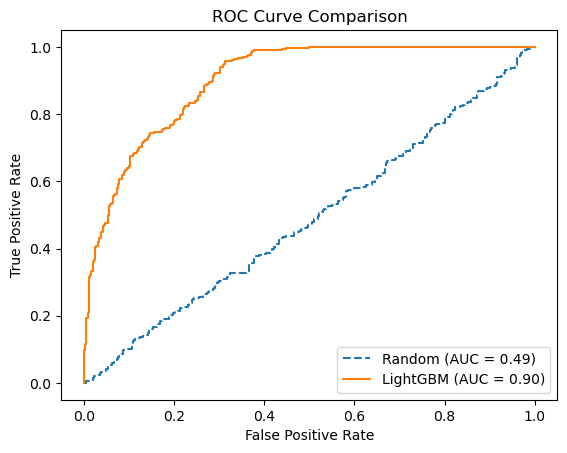

In [ ]:
# Import necessary libraries
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Assuming test_df["label"] contains the true labels for your test data

# Generate random predictions (assuming a binary classification problem)
random_predictions = np.random.rand(len(test_df))

# Compute ROC curve and AUC for the random classifier
fpr_random, tpr_random, thresholds_random = roc_curve(test_df["label"], random_predictions)
auc_random = roc_auc_score(test_df["label"], random_predictions)

# Compute ROC curve and AUC for the LightGBM model
y_pred_proba = lgbm.predict_proba(test_df.drop(columns=["label"]))
fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(test_df["label"], y_pred_proba[:, 1])
auc_lgbm = roc_auc_score(test_df["label"], y_pred_proba[:, 1])

# Plot ROC curves
plt.plot(fpr_random, tpr_random, linestyle='--', label=f'Random (AUC = {auc_random:.2f})')
plt.plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM (AUC = {auc_lgbm:.2f})')

# Customize plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


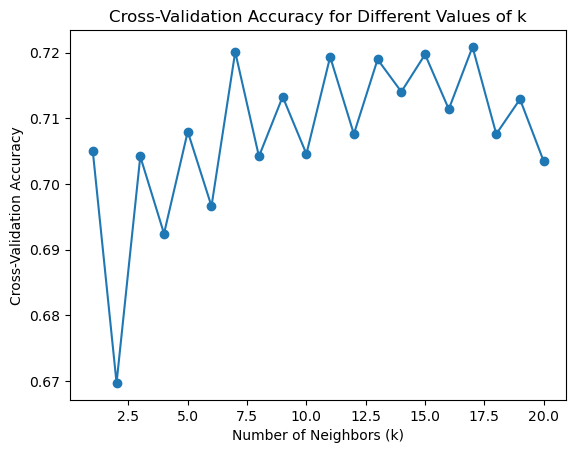

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd

# Assume you have your features X and labels y
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a KNN classifier
knn = KNeighborsClassifier()

# Define a range of k values to test
k_values = np.arange(1, 21)

# Perform cross-validation for each k value
cross_val_scores = []

for k in k_values:
    knn.n_neighbors = k
    scores = cross_val_score(knn, train_df.drop(columns=["label"]), train_df["label"], cv=5, scoring="accuracy")
    cross_val_scores.append(np.mean(scores))

# Plot the cross-validation scores for each k
plt.plot(k_values, cross_val_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Cross-Validation Accuracy for Different Values of k')
plt.show()


In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import KFold, train_test_split
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score


# Vary the training set size from 10% to 100%
training_sizes = np.arange(0.6, 1.1, 0.1)

# Initialize lists to store performance metrics
svm_accuracies = []
lgbm_accuracies = []
datasets = pd.concat([train_df, test_df], axis=0)
X_data = datasets.drop(columns=["label"])
y_data = datasets["label"]
# Loop through different training set sizes
for size in training_sizes:
    print(f"Training Size: {size:.2f}")
    size = min(size, 0.9999)
    

    num_samples = int(size * len(datasets))


    # Define the number of folds
    num_folds = 5

    # Create a KFold object
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    X_train_subset, _, y_train_subset, _ = train_test_split(X_data, y_data, train_size=num_samples, random_state=42)

    # SVM Training
    svm_model = SVC(kernel="linear", C=10, gamma=0.1, random_state=42)
    svm_result = cross_val_score(svm_model, X_train_subset, y_train_subset, cv=kf, scoring='accuracy', n_jobs=-1, verbose=10)
    
    # LightGBM Training
    lgbm_model = LGBMClassifier(  
        subsample=0.7,
        reg_lambda=0.01,
        reg_alpha=0.001,
        num_leaves=64,
        n_estimators=500,
        min_split_gain=0.0105,
        min_child_weight=20,
        max_depth=10,
        learning_rate=0.01,
        colsample_bytree=0.6,
        silent=-1,
        verbose=-1,
    )
    lgmb_result = cross_val_score(lgbm_model, X_train_subset, y_train_subset, cv=kf, scoring='accuracy', n_jobs=-1, verbose=10)
    
    
    # Append the accuracies to the lists
    svm_accuracies.append(svm_result)
    lgbm_accuracies.append(lgmb_result)
    # save to csv
    df = pd.DataFrame(svm_accuracies, columns=["fold1", "fold2", "fold3", "fold4", "fold5"])
    df.to_csv(f"data/svm_accuracies_{size:.2f}.csv", index=False, float_format="%.5f")

    df = pd.DataFrame(lgbm_accuracies, columns=["fold1", "fold2", "fold3", "fold4", "fold5"])
    df.to_csv(f"data/lgbm_accuracies_{size:.2f}.csv", index=False, float_format="%.5f")
    
    
    
    



Training Size: 0.60


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  8.4min remaining: 12.6min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  8.7min remaining:  5.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 69.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 69.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.0s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    6.2s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Training Size: 0.70


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  9.6min remaining: 14.3min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 11.7min remaining:  7.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 36.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 36.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.1s remaining:   12.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    8.1s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.2s finished


Training Size: 0.80


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 13.2min remaining: 19.8min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 13.7min remaining:  9.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 16.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 16.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.7s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    4.8s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Training Size: 0.90


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 12.5min remaining: 18.8min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 12.8min remaining:  8.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 29.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 29.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.3s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    8.4s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.4s finished


Training Size: 1.00


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 14.0min remaining: 21.0min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 16.7min remaining: 11.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 27.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 27.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.1s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    7.3s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Training Size: 1.10


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 12.8min remaining: 19.2min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 15.3min remaining: 10.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 25.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 25.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.7s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    7.1s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.2s finished


In [5]:
import numpy as np
from dask.distributed import Client

import joblib
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from dask_ml.model_selection import train_test_split

client = Client(processes=False)             # create local cluster

datasets = pd.concat([train_df, test_df], axis=0)

param_space = {
    'C': np.logspace(-6, 6, 13),
    'gamma': np.logspace(-8, 8, 17),
    'tol': np.logspace(-4, -1, 4),
    'class_weight': [None, 'balanced'],
}

model = SVC(kernel='rbf')
svm_model = SVC(kernel="linear", C=10, gamma=0.1, random_state=42)
num_folds = 5  # You can choose the number of folds (e.g., 5 or 10)

# Create a KFold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)


with joblib.parallel_backend('dask'):
    cross_val_results = cross_val_score(knn, X_train, y_train, cv=kf, scoring='accuracy')


In [2]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
import numpy as np

# Assuming train_df and test_df are Dask DataFrames
datasets = pd.concat([train_df, test_df], axis=0)


X_data = datasets.drop(columns=["label"])
y_data = datasets["label"]

# Define the number of folds
num_folds = 5

# Create a KFold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Create an SVM model
svm = SVC(kernel="linear", C=10, gamma=0.1, random_state=42)



# Use cross_val_score with Pandas DataFrame

# Print the result
print(result)
print(f"Mean Accuracy: {np.mean(result)}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


[0.82272727 0.80909091 0.79362671 0.79666161 0.74962064]
Mean Accuracy: 0.7943454269554422


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 25.3min finished
